# 2487 Machine Learning Assignment 4
#Inside Out
![](https://upload.wikimedia.org/wikipedia/en/0/0a/Inside_Out_%282015_film%29_poster.jpg)




Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise.

Your task is to use deep learning techniques to classify the Tweets into the corresponding emotions:

In [123]:
!pip install datasets transformers

In [131]:
from datasets import load_dataset

In [132]:
emotion = load_dataset("dair-ai/emotion")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Data Fields

The data fields are:

- text: a string feature.
- label: a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

In [107]:
emotion['train'][0]['text'],emotion['train'][0]['label'],emotion['train'].features

('i didnt feel humiliated',
 0,
 {'text': Value(dtype='string', id=None),
  'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)})

In [ ]:
emotion['validation'][0]['text'],emotion['validation'][0]['label']

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
emotion['test'][0]['text'],emotion['test'][0]['label']

('im feeling rather rotten so im not very ambitious right now', 0)

split: with a total of 20_000 examples split into train, validation and split

In [ ]:
emotion['train'].shape, emotion['validation'].shape, emotion['test'].shape

((16000, 2), (2000, 2), (2000, 2))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [133]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [109]:
train_texts = emotion['train']['text']
word_counts = [len(text.split()) for text in train_texts]
max_words_train = max(word_counts)
min_words_train = min(word_counts)

print(max_words_train, min_words_train)

66 2


In [110]:
val_texts = emotion['validation']['text']
word_counts_val = [len(text.split()) for text in val_texts]
max_words_val = max(word_counts_val)
min_words_val =min(word_counts_val)
print(max_words_val, min_words_val)

61 2


In [111]:
test_texts = emotion['validation']['text']
word_counts_test = [len(text.split()) for text in test_texts]
max_words_test = max(word_counts_test)
min_words_test = min(word_counts_test)

print(max_words_test, min_words_test)

61 2


## Question 1 (40 points)
Check the distribution of the text length in the data, build the simple RNN model and LSTM model with one layer, and two stacked layers, respectively and compare their performance. You may choose to pad or truncate the input sequence to be the number closest to 128, 256, 512, etc. You could train at most for 10 epochs if you find it takes much time.

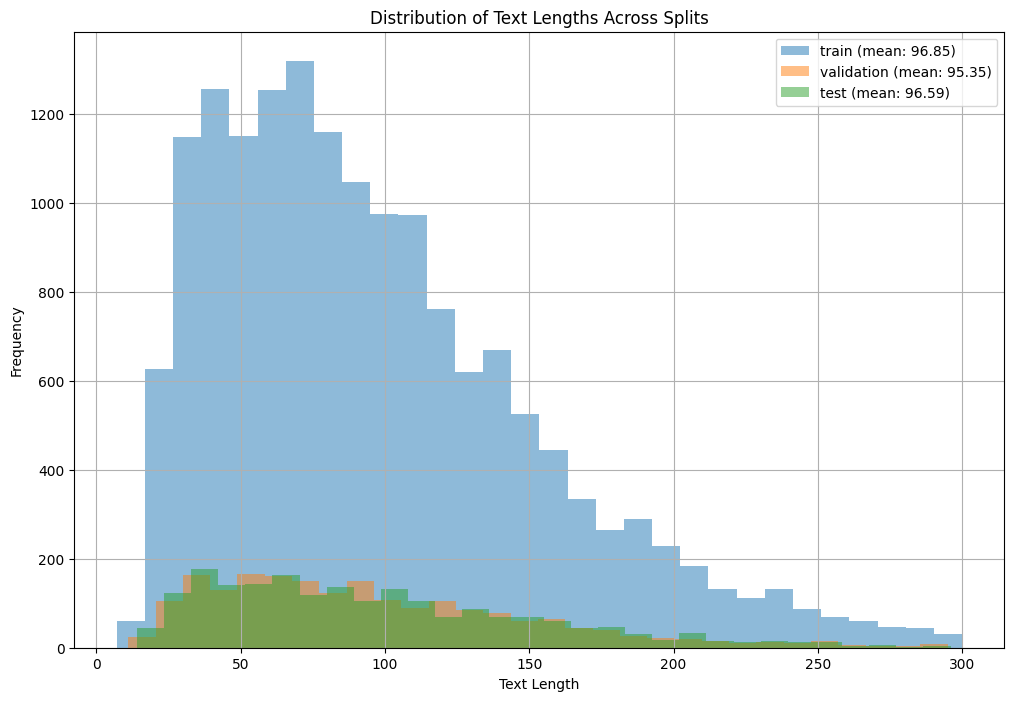

In [ ]:
# Access the text from the dataset and calculate length
text_lengths = {split: [len(text) for text in emotion[split]['text']] for split in emotion.keys()}

# Plot the distribution of text lengths for each split
plt.figure(figsize=(12, 8))
for split, lengths in text_lengths.items():
    plt.hist(lengths, bins=30, alpha=0.5, label=f'{split} (mean: {sum(lengths) / len(lengths):.2f})')

plt.title('Distribution of Text Lengths Across Splits')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [148]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Combine texts from train, validation, and test sets
texts_train = emotion['train']['text']
texts_val = emotion["validation"]["text"]
texts_test = emotion["test"]["text"]

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

# Fit the tokenizer on the training data only
tokenizer.fit_on_texts(texts_train)

# Convert all texts to sequences using the same tokenizer
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_val = tokenizer.texts_to_sequences(texts_val)
sequences_test = tokenizer.texts_to_sequences(texts_test)


In [149]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 64

# Pad sequences
train_padded = pad_sequences(sequences_train, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(sequences_val, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')

In [150]:
# one hot encoding for labels
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(emotion['train']['label'])
val_labels = to_categorical(emotion['validation']['label'])
test_labels = to_categorical(emotion['test']['label'])

In [ ]:
train_labels[:5]


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense

In [ ]:
# Simple RNN Model

model_rnn = Sequential([
    Embedding(input_dim=10000, output_dim=64, mask_zero=True),  # Adjust as per your vocab size and sequence length
    SimpleRNN(64),
    Dense(6, activation='softmax')  # Output layer for 6 classes
])

In [ ]:
# LSTM Model with One Layer

model_lstm_1 = Sequential([
    Embedding(input_dim=10000, output_dim=64, mask_zero=True),
    LSTM(64),
    Dense(6, activation='softmax')
])


In [ ]:
#LSTM Model with Two Stacked Layers

model_lstm_2 = Sequential([
    Embedding(input_dim=10000, output_dim=64, mask_zero=True),
    LSTM(64, return_sequences=True),  # Enable passing output to another LSTM layer
    LSTM(64),
    Dense(6, activation='softmax')
])


In [ ]:
# Compile the models

models = [model_rnn, model_lstm_1, model_lstm_2]
for model in models:
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the models

history_rnn = model_rnn.fit(train_padded, train_labels, epochs=10, validation_data=(val_padded, val_labels))
history_lstm_1 = model_lstm_1.fit(train_padded, train_labels, epochs=10, validation_data=(val_padded, val_labels))
history_lstm_2 = model_lstm_2.fit(train_padded, train_labels, epochs=10, validation_data=(val_padded, val_labels))


Epoch 1/10
500/500 [==============================] - 17s 31ms/step - loss: 1.4591 - accuracy: 0.4251 - val_loss: 1.0015 - val_accuracy: 0.6550
Epoch 2/10
500/500 [==============================] - 16s 32ms/step - loss: 0.6324 - accuracy: 0.7888 - val_loss: 0.6637 - val_accuracy: 0.7820
Epoch 3/10
500/500 [==============================] - 15s 30ms/step - loss: 0.2656 - accuracy: 0.9182 - val_loss: 0.6638 - val_accuracy: 0.7915
Epoch 4/10
500/500 [==============================] - 15s 30ms/step - loss: 0.1296 - accuracy: 0.9614 - val_loss: 0.6824 - val_accuracy: 0.7925
Epoch 5/10
500/500 [==============================] - 15s 31ms/step - loss: 0.0766 - accuracy: 0.9781 - val_loss: 0.6939 - val_accuracy: 0.7980
Epoch 6/10
500/500 [==============================] - 15s 31ms/step - loss: 0.0607 - accuracy: 0.9832 - val_loss: 0.7205 - val_accuracy: 0.8130
Epoch 7/10
500/500 [==============================] - 15s 30ms/step - loss: 0.0416 - accuracy: 0.9888 - val_loss: 0.7592 - val_accuracy:

In [ ]:
performance_rnn = model_rnn.evaluate(test_padded, test_labels)
performance_lstm_1 = model_lstm_1.evaluate(test_padded, test_labels)
performance_lstm_2 = model_lstm_2.evaluate(test_padded, test_labels)

print("Simple RNN Test Accuracy:", performance_rnn[1])
print("LSTM 1 Layer Test Accuracy:", performance_lstm_1[1])
print("LSTM 2 Layers Test Accuracy:", performance_lstm_2[1])


63/63 [==============================] - 1s 22ms/step - loss: 0.3206 - accuracy: 0.9115
Simple RNN Test Accuracy: 0.7785000205039978
LSTM 1 Layer Test Accuracy: 0.9100000262260437
LSTM 2 Layers Test Accuracy: 0.9114999771118164


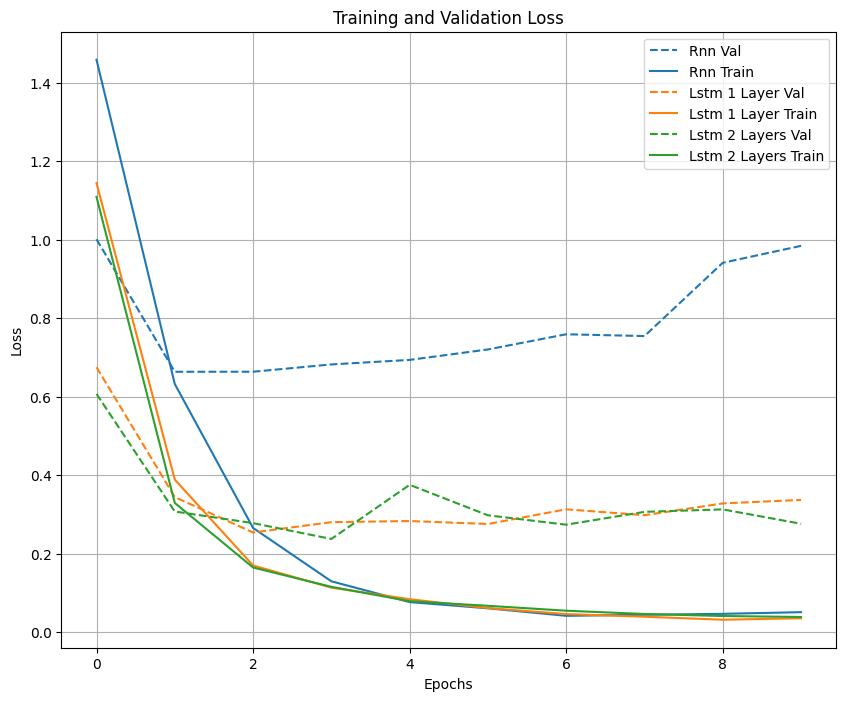

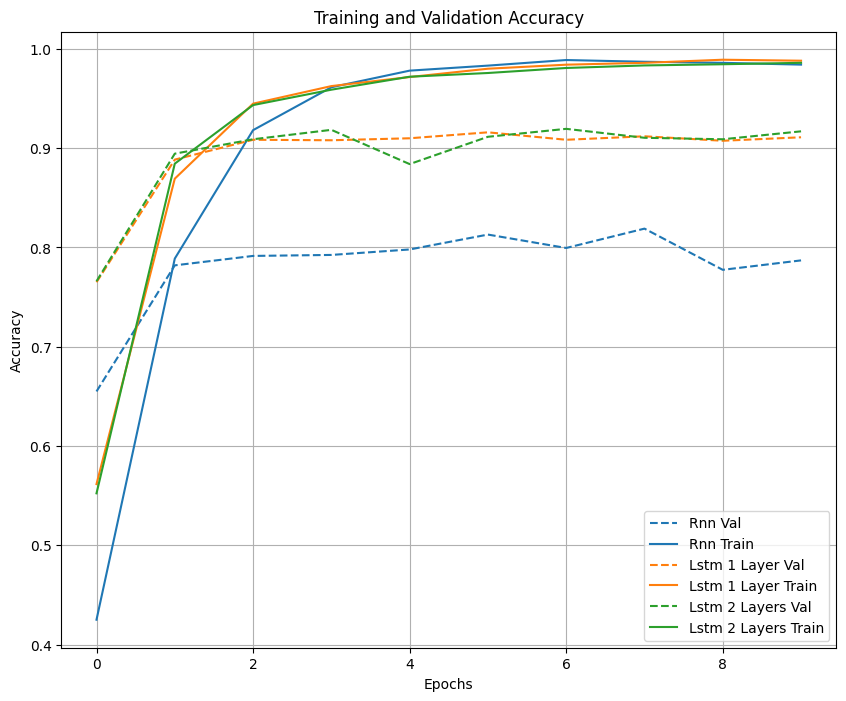

In [ ]:
def plot_history(histories, key='loss'):
    plt.figure(figsize=(10, 8))
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.title('Training and Validation ' + key.title())
    plt.xlabel('Epochs')
    plt.ylabel(key.title())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history([
    ('RNN', history_rnn),
    ('LSTM 1 Layer', history_lstm_1),
    ('LSTM 2 Layers', history_lstm_2)
], key='loss')

plot_history([
    ('RNN', history_rnn),
    ('LSTM 1 Layer', history_lstm_1),
    ('LSTM 2 Layers', history_lstm_2)
], key='accuracy')


## Question 2 (30 points)

Now download the pretrained word embedding models from Gensim library with different embedding size 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200'. Show the most similar words for `anger, fear, joy, love, sadness, and surprise`. Use the best performing model from the Quesetion 1 and replace the embedding layer with pretrained word embeddings with different embedding size. Explain whether these pretrained embedding would imporve the model performance.


In [154]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [155]:
glove_twitter_25 = gensim.downloader.load('glove-twitter-25')
glove_twitter_50 = gensim.downloader.load('glove-twitter-50')
glove_twitter_100 = gensim.downloader.load('glove-twitter-100')
glove_twitter_200 = gensim.downloader.load('glove-twitter-200')


[==================================================] 100.0% 104.8/104.8MB downloaded
[==================================================] 100.0% 199.5/199.5MB downloaded
[==================================================] 100.0% 387.1/387.1MB downloaded
[==================================================] 100.0% 758.5/758.5MB downloaded


In [156]:
models = {
    'glove-twitter-25': glove_twitter_25,
    'glove-twitter-50': glove_twitter_50,
    'glove-twitter-100': glove_twitter_100,
    'glove-twitter-200': glove_twitter_200
}

# List of emotion words to investigate
emotion_words = ["anger", "fear", "joy", "love", "sadness", "surprise"]

# Loop through each model
for model_name, model in models.items():
    print(f"--- Similar Words using {model_name} ---")
    # Loop through each word and find the most similar words
    for word in emotion_words:
        try:
            # Using try-except to handle cases where the word might not be in the vocabulary
            similar_words = model.most_similar(word)
            print(f"Words similar to '{word}':")
            for similar_word, similarity in similar_words:
                print(f"  {similar_word} ({similarity:.2f})")
            print()  # Blank line for better readability between word groups
        except KeyError:
            print(f"The word '{word}' is not in the vocabulary.")
    print("\n")  # Separate models by a newline for clarity


--- Similar Words using glove-twitter-25 ---
Words similar to 'anger':
  fear (0.95)
  frustration (0.94)
  emotions (0.91)
  pain (0.91)
  emotion (0.90)
  hatred (0.90)
  enemy (0.90)
  confusion (0.90)
  loneliness (0.90)
  jealousy (0.89)

Words similar to 'fear':
  anger (0.95)
  enemy (0.92)
  afraid (0.91)
  destroy (0.91)
  fears (0.91)
  lies (0.90)
  faith (0.89)
  hatred (0.89)
  overcome (0.89)
  truth (0.89)

Words similar to 'joy':
  dreams (0.92)
  faith (0.91)
  grace (0.91)
  happiness (0.91)
  spirit (0.91)
  lord (0.90)
  heaven (0.90)
  soul (0.90)
  god (0.89)
  wisdom (0.89)

Words similar to 'love':
  you (0.94)
  baby (0.94)
  dream (0.93)
  miss (0.92)
  much (0.92)
  see (0.92)
  happy (0.92)
  beautiful (0.92)
  smile (0.91)
  loves (0.91)

Words similar to 'sadness':
  heartbreak (0.92)
  laughter (0.92)
  sorrow (0.92)
  heartache (0.91)
  misery (0.91)
  happiness (0.89)
  loneliness (0.88)
  anger (0.88)
  despair (0.88)
  fear (0.88)

Words similar to 's

In [157]:
word_index = tokenizer.word_index
print("Word Index:", word_index)

Word Index: {'<OOV>': 1, 'i': 2, 'feel': 3, 'and': 4, 'to': 5, 'the': 6, 'a': 7, 'feeling': 8, 'that': 9, 'of': 10, 'my': 11, 'in': 12, 'it': 13, 'like': 14, 'so': 15, 'for': 16, 'im': 17, 'me': 18, 'but': 19, 'was': 20, 'have': 21, 'is': 22, 'this': 23, 'am': 24, 'with': 25, 'not': 26, 'about': 27, 'be': 28, 'as': 29, 'on': 30, 'you': 31, 'just': 32, 'at': 33, 'when': 34, 'or': 35, 'all': 36, 'because': 37, 'more': 38, 'do': 39, 'can': 40, 'really': 41, 'up': 42, 't': 43, 'are': 44, 'by': 45, 'very': 46, 'know': 47, 'been': 48, 'if': 49, 'out': 50, 'myself': 51, 'time': 52, 'how': 53, 'what': 54, 'get': 55, 'little': 56, 'had': 57, 'now': 58, 'will': 59, 'from': 60, 'being': 61, 'they': 62, 'people': 63, 'them': 64, 'would': 65, 'he': 66, 'want': 67, 'her': 68, 'some': 69, 'think': 70, 'one': 71, 'still': 72, 'ive': 73, 'him': 74, 'even': 75, 'who': 76, 'an': 77, 'life': 78, 'its': 79, 'make': 80, 'there': 81, 'we': 82, 'bit': 83, 'something': 84, 'love': 85, 'much': 86, 'going': 87, 

In [169]:
def run_models_with_different_embeddings(word_index, max_length, train_padded, train_labels, val_padded, val_labels, test_padded, test_labels):

    embedding_sizes = [25, 50, 100, 200]
    results = {}
    histories = {}  # To store training histories for plotting

    for size in embedding_sizes:
        print(f"Loading GloVe Twitter embeddings with {size} dimensions...")
        # Retrieve model from dictionary
        glove_model = models  # Ensure 'models' is correctly defined and accessible here

        # Prepare the embedding matrix
        vocab_size = len(word_index) + 1
        embedding_matrix = np.zeros((vocab_size, size))
        for word, i in word_index.items():
            if i < vocab_size:
                embedding_vector = glove_model.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector

        # Define the model
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=size, weights=[embedding_matrix], input_length=max_length, trainable=True, mask_zero=True),
            LSTM(units=64),
            Dense(6, activation='softmax')
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        print(f"Training model with {size} dimensions...")
        history = model.fit(train_padded, train_labels, epochs=10, validation_data=(val_padded, val_labels))

        # Evaluate the model on test data
        test_loss, test_acc = model.evaluate(test_padded, test_labels)
        print(f"Test Accuracy for {size} dimensions: {test_acc}")

        # Store results
        results[size] = {
            'val_accuracy': max(history.history['val_accuracy']),
            'test_accuracy': test_acc
        }
        histories[size] = history  # Store history for later plotting

    return results, histories  # Correct return statement

# Usage
results, histories = run_models_with_different_embeddings(word_index, max_length, train_padded, train_labels, val_padded, val_labels, test_padded, test_labels)
print(results)


Loading GloVe Twitter embeddings with 25 dimensions...
Training model with 25 dimensions...
Epoch 1/10
500/500 [==============================] - 27s 48ms/step - loss: 1.3313 - accuracy: 0.4709 - val_loss: 0.8391 - val_accuracy: 0.7330
Epoch 2/10
500/500 [==============================] - 21s 41ms/step - loss: 0.4864 - accuracy: 0.8429 - val_loss: 0.4066 - val_accuracy: 0.8630
Epoch 3/10
500/500 [==============================] - 21s 42ms/step - loss: 0.2210 - accuracy: 0.9256 - val_loss: 0.2929 - val_accuracy: 0.8970
Epoch 4/10
500/500 [==============================] - 20s 40ms/step - loss: 0.1391 - accuracy: 0.9544 - val_loss: 0.2725 - val_accuracy: 0.9075
Epoch 5/10
500/500 [==============================] - 20s 40ms/step - loss: 0.1011 - accuracy: 0.9666 - val_loss: 0.2623 - val_accuracy: 0.9195
Epoch 6/10
500/500 [==============================] - 20s 40ms/step - loss: 0.0747 - accuracy: 0.9767 - val_loss: 0.2947 - val_accuracy: 0.9120
Epoch 7/10
500/500 [========================

In [170]:
def plot_model_performances(histories):
    plt.figure(figsize=(14, 6))

    # Subplot for Accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    for size, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'Train Accuracy ({size}d)')
        plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy ({size}d)', linestyle='--')
    plt.title('Model Accuracy by Embedding Size')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Subplot for Loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    for size, history in histories.items():
        plt.plot(history.history['loss'], label=f'Train Loss ({size}d)')
        plt.plot(history.history['val_loss'], label=f'Validation Loss ({size}d)', linestyle='--')
    plt.title('Model Loss by Embedding Size')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


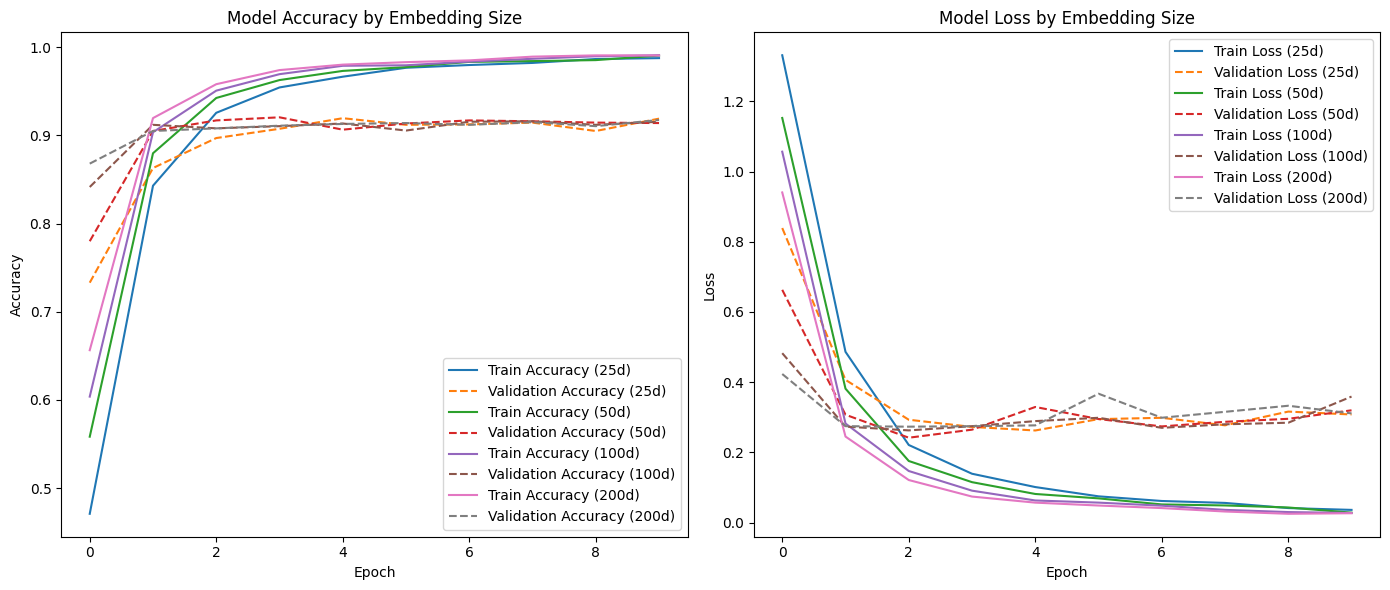

In [171]:
plot_model_performances(histories)

After analyzing the performance metrics of different models trained on our dataset, it's evident that the choice of embedding dimensions plays a crucial role in model effectiveness. Surprisingly, the simpler models that utilize Gensim library embeddings often outperform or closely match the more complex two-layer LSTM model. Specifically, models with 200-dimensional embeddings showcased the highest accuracy, achieving a remarkable 0.9190, which slightly surpasses the LSTM model's 0.9115 accuracy.

This observation underscores the potential impact of high-quality embeddings in text classification tasks. It seems that embedding dimensionality, particularly at higher levels, is critical in capturing the nuanced semantic details necessary for accurate classification. The 200-dimensional embeddings provide a rich, expressive feature set that enhances model performance, likely due to their ability to encapsulate more detailed semantic relationships within the data.

On the other hand, the drop in performance with 100-dimensional embeddings to 0.9005 suggests a possible 'middle ground' where the embeddings do not sufficiently represent the complexity of the data, nor are they compact enough to avoid overfitting. This result is intriguing as it highlights a non-linear relationship between dimensionality and model efficacy, prompting further investigation into the optimal size of embeddings for different types of text data.

## Question 3 (20 points)

Now load BERT models from TensorFlow Hub. Fine-tune it with the data and evaluate the model performance. Check how you can do it [here](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

In [ ]:
!pip install tensorflow-hub
!pip install tensorflow-text==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 27.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Load BERT model and preprocessing from TensorFlow Hub
bert_preprocess_model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_model_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1"

preprocessing_layer = hub.KerasLayer(bert_preprocess_model_url, name='preprocessing')
encoder_layer = hub.KerasLayer(bert_model_url, trainable=True, name='BERT_encoder')

In [80]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((emotion['train']['text'], emotion['train']['label'])).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((emotion['validation']['text'], emotion['validation']['label'])).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((emotion['test']['text'], emotion['test']['label'])).batch(batch_size)


In [84]:
def build_classifier_model(preprocessing_layer, encoder_layer):
    # Define the input layer
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Add the preprocessing KerasLayer
    preprocessing = hub.KerasLayer(preprocessing_layer, name='preprocessing')
    encoder_inputs = preprocessing(text_input)

    # Add the BERT encoder KerasLayer
    encoder = hub.KerasLayer(encoder_layer, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    # Add a dropout layer
    net = tf.keras.layers.Dropout(0.1)(outputs['pooled_output'])

    # Add a dense layer for classification
    net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)

    # Create the Keras model
    return tf.keras.Model(inputs=text_input, outputs=net)

# Assuming the preprocessing_layer and encoder_layer are defined with their URLs:
preprocessing_layer = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_layer = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1"

# Build the model
classifier_model = build_classifier_model(preprocessing_layer, encoder_layer)

# Print the model summary to verify the architecture
print(classifier_model.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                            

In [88]:
# Compile the model
classifier_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model
history = classifier_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
500/500 [==============================] - 86s 166ms/step - loss: 0.2602 - accuracy: 0.9029 - val_loss: 0.3298 - val_accuracy: 0.8825
Epoch 2/5
500/500 [==============================] - 83s 166ms/step - loss: 0.2688 - accuracy: 0.9036 - val_loss: 0.3294 - val_accuracy: 0.8885
Epoch 3/5
500/500 [==============================] - 85s 170ms/step - loss: 0.2621 - accuracy: 0.9049 - val_loss: 0.3476 - val_accuracy: 0.8840
Epoch 4/5
500/500 [==============================] - 87s 173ms/step - loss: 0.2409 - accuracy: 0.9076 - val_loss: 0.3168 - val_accuracy: 0.8890
Epoch 5/5
500/500 [==============================] - 88s 177ms/step - loss: 0.2088 - accuracy: 0.9205 - val_loss: 0.3138 - val_accuracy: 0.8910


In [89]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = classifier_model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

63/63 [==============================] - 4s 59ms/step - loss: 0.3210 - accuracy: 0.8775
Test Loss: 0.32103997468948364
Test Accuracy: 0.8774999976158142


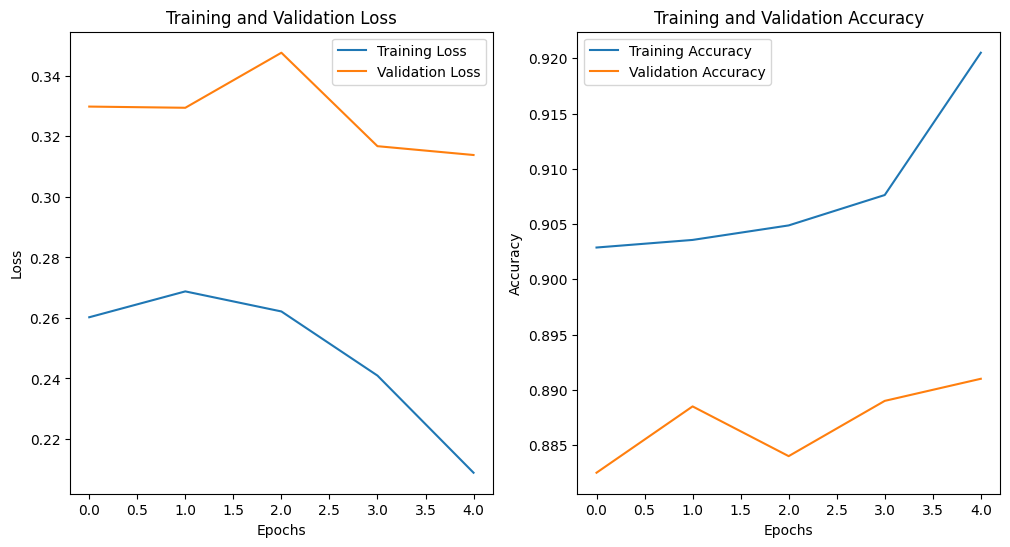

In [90]:
# Extracting the history of training and validation loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Creating figure for plotting
plt.figure(figsize=(12, 6))

# Plotting training and validation losses
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Showing the plots
plt.show()


# Question 4 (10 points)

Now let's try some state-of-the-art Large Language Models (LLM)! Cohere provides trial API for free and you may register and use the LLM. After you obtain the trial API, go to https://dashboard.cohere.com/playground/classify and see how the LLM-based classification works. You could choose several pretrained embedding models such as embed-engligh-2.0 or embed-engligh-3.0 and provide example training data. Evaluate the model performance.

In [95]:
pip install cohere

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.7 MB/s eta 0:00:00


In [144]:
import cohere
import random
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define the emotion categories
emotions = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
reverse_emotion_map = {value: key for key, value in emotions.items()}

# Collect training examples for each emotion category
training_examples = []
samples_per_emotion = 5

for emotion_id, emotion_name in emotions.items():
    # Gather data for the current emotion
    specific_emotion_data = [record for record in emotion["train"] if record['label'] == emotion_id]
    # Random selection of examples
    selected_examples = random.choices(specific_emotion_data, k=samples_per_emotion)
    # Compile examples
    for example in selected_examples:
        training_examples.append({'text': example['text'], 'label': emotion_name})

# Set up Cohere API client
cohere_client = cohere.Client('8i1XdP3OF1AuSYFI2Cvt6BptYCFHKm5vltGQABQW')

# Assemble test inputs and their corresponding labels
test_texts = [entry['text'] for entry in emotion["test"]]
actual_labels = [entry['label'] for entry in emotion["test"]]

# Record the start time
start_time = time.time()

# Classify test inputs in batches
classification_results = []
all_responses = []
batch_size = 50
for start in range(0, len(test_texts), batch_size):
    print(f'Processing batch {(start // batch_size) + 1} / {((len(test_texts) - 1) // batch_size) + 1}')
    current_batch = test_texts[start:start + batch_size]
    classify_result = cohere_client.classify(
        model='embed-english-v3.0',
        inputs=current_batch,
        examples=training_examples
    )
    # Retrieve predictions and map them to numeric labels
    current_predictions = [reverse_emotion_map[result.prediction] for result in classify_result.classifications]
    classification_results.extend(current_predictions)
    all_responses.extend(classify_result.classifications)

# Calculate elapsed time
finish_time = time.time()
total_classification_time = finish_time - start_time

# Compute performance metrics
computed_accuracy = accuracy_score(actual_labels, classification_results)
computed_precision = precision_score(actual_labels, classification_results, average='macro')
computed_recall = recall_score(actual_labels, classification_results, average='macro')

# Display the performance metrics
print('\nPerformance Metrics:')
print('-' * 20)
print(f"Accuracy: {computed_accuracy:.4f}")
print(f"Precision: {computed_precision:.4f}")
print(f"Recall: {computed_recall:.4f}")
print(f"Total Classification Time: {total_classification_time:.2f} seconds\n")


Processing batch 1 / 40
Processing batch 2 / 40
Processing batch 3 / 40
Processing batch 4 / 40
Processing batch 5 / 40
Processing batch 6 / 40
Processing batch 7 / 40
Processing batch 8 / 40
Processing batch 9 / 40
Processing batch 10 / 40
Processing batch 11 / 40
Processing batch 12 / 40
Processing batch 13 / 40
Processing batch 14 / 40
Processing batch 15 / 40
Processing batch 16 / 40
Processing batch 17 / 40
Processing batch 18 / 40
Processing batch 19 / 40
Processing batch 20 / 40
Processing batch 21 / 40
Processing batch 22 / 40
Processing batch 23 / 40
Processing batch 24 / 40
Processing batch 25 / 40
Processing batch 26 / 40
Processing batch 27 / 40
Processing batch 28 / 40
Processing batch 29 / 40
Processing batch 30 / 40
Processing batch 31 / 40
Processing batch 32 / 40
Processing batch 33 / 40
Processing batch 34 / 40
Processing batch 35 / 40
Processing batch 36 / 40
Processing batch 37 / 40
Processing batch 38 / 40
Processing batch 39 / 40
Processing batch 40 / 40

Performa

<ipython-input-146-f27aeb5d9559>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='muted')


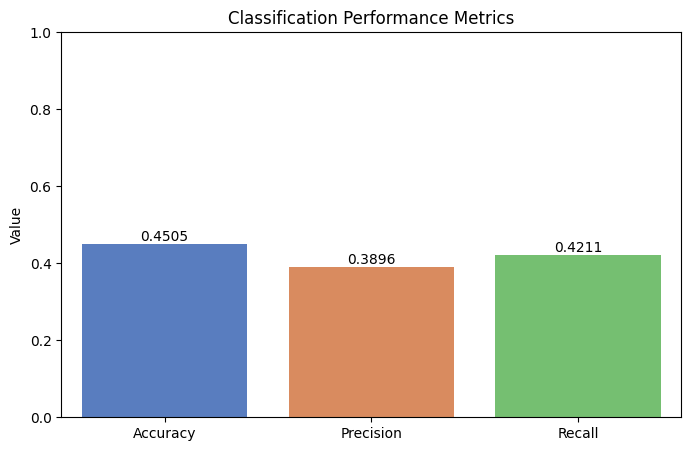

In [146]:
# Metrics data
metrics = ['Accuracy', 'Precision', 'Recall']
values = [computed_accuracy, computed_precision, computed_recall]

# Creating bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette='muted')
plt.title('Classification Performance Metrics')
plt.ylabel('Value')
plt.ylim(0, 1)  # Setting limit for y-axis for better readability
for index, value in enumerate(values):
    plt.text(index, value, f'{value:.4f}', ha='center', va='bottom')
plt.show()


Reflecting on the performance metrics and the detailed analysis provided, it's clear that while the model's current effectiveness is limited, there is substantial room for improvement. The accuracy of 45.05%, along with precision and recall below 50%, underscores a need for a deeper dive into both the model architecture and the data it's being trained on.

Given the nature of the dataset, which includes a variety of text data possibly sourced from diverse platforms, the challenge might lie in adequately capturing the semantic richness required for accurate classification. The use of GloVe Twitter embeddings might not be optimal if the language or sentiment expressions in the dataset diverge significantly from the data these embeddings were trained on.